# 1. 모듈 로딩

In [ ]:
# import module
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tensorflow.keras.preprocessing import image
from tensorflow.keras import (Input, Model, layers, losses, optimizers, metrics, utils, models)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# 2. 데이터 불러오기

In [ ]:
# Kaggle dataset 다운로드
os.environ['KAGGLE_CONFIG_DIR'] = "/content" 
!kaggle datasets download -d gpiosenka/sports-classification

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# dataset 압축해제
!unzip sports-classification.zip

In [ ]:
# dataset path 지정
from pathlib import Path
train_path = Path("/content/train")
train_path.glob(r'**/*.jpg')

val_path = Path("/content/valid")
val_path.glob(r'**/*.jpg')

test_path = Path("/content/test")
test_path.glob(r'**/*.jpg')

# 3. 파라미터 지정

In [ ]:
# 파라미터 설정
image_size = (224, 224) # 이미지 크기
image_shape = (224, 224, 3) # 이미지 모양
num_classes = len(os.listdir(test_path)) # 이미지 종류(집단수)
epoch = 30
batch = 100
learning_rate = 0.001

# 4. 이미지 제너레이터 : 이미지 증식

In [ ]:
# 이미지 증식 (과적합 해결)
train_data_generator = image.ImageDataGenerator(
                                            rotation_range=30,
                                            zoom_range=0.15,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.15,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            preprocessing_function=preprocess_input
                                            )

test_data_generator = image.ImageDataGenerator(
                                            preprocessing_function=preprocess_input
                                            )

train_generator = train_data_generator.flow_from_directory(directory= train_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch)

val_generator = train_data_generator.flow_from_directory(directory= val_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch)

test_generator = test_data_generator.flow_from_directory(directory= test_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch)

# 5. 모델 생성

In [ ]:
# MobileNet Class 생성
class ModifiedMobileNet():
    '''
    This class creates the mobilenet model.
    '''
    def __init__(self, input_shape, nb_classes):
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        
    def get_model(self, unfreeze_layers = None, lr_rate = 0.001):
        # load base model
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        
        # freezing the layers
        for layer in (base_model.layers) if not unfreeze_layers else (base_model.layers[:-int(unfreeze_layers)]):
            layer.trainable = False

        # Fine Tuning    
        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(self.nb_classes, activation='softmax')(x)
        model = Model(inputs, outputs)
        
        # model compilation
        optimizer = optimizers.Adam(learning_rate=lr_rate)
        model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
        return model

In [ ]:
# 모델 훈련
mobilenet = ModifiedMobileNet(input_shape= image_shape, nb_classes= num_classes)
model = mobilenet.get_model(unfreeze_layers= 0, lr_rate= learning_rate)

model.compile(optimizer = optimizers.Adam(learning_rate), 
                loss = losses.categorical_crossentropy, 
                metrics = ['accuracy'])
history = model.fit(train_generator, validation_data= val_generator, epochs = epoch)
# 최종 결과 : - loss: 0.4519 - accuracy: 0.8586 - val_loss: 0.4271 - val_accuracy: 0.8620

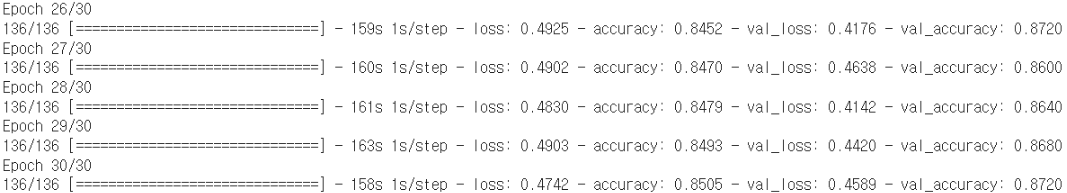

In [ ]:
# save model
model.save('mobilenet_model.h5')

# 6. 히스토리 시각화

In [ ]:
max = len(history.history['accuracy'])
epochs = range(1, max+1) 

# acc vs val_acc   
plt.plot(epochs, history.history['accuracy'], 'b--', label='train acc')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='val acc')
plt.title('Training vs validation accuracy')
plt.xlabel('epoch') 
plt.ylabel('accuray')
plt.legend(loc='best')
plt.show()

# loss vs val_loss 
plt.plot(epochs, history.history['loss'], 'b--', label='train loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='val loss')
plt.title('Training vs validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

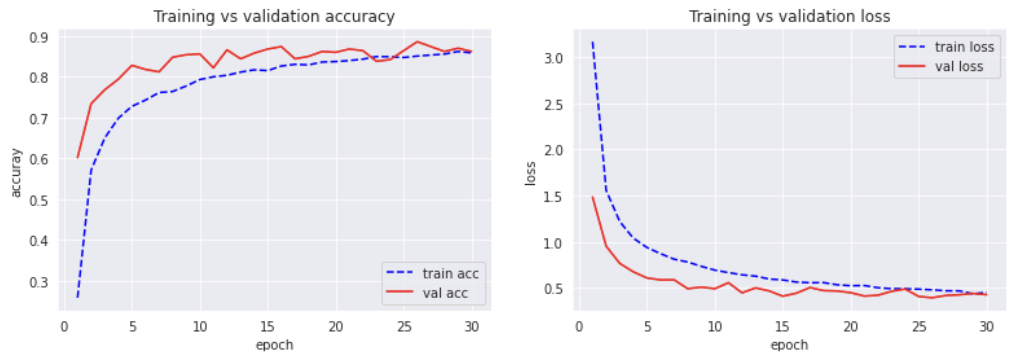

# 7. 모델 평가

In [ ]:
# load model
model = load_model('/content/mobilenet_model.h5')

## - 테스트 데이터 예측 결과 평가

In [ ]:
# Model Evaluation : Test Dataset
score2 = model.evaluate(test_generator)
print('acc = ', score2[1], 'loss = ', score2[0])
# acc =  0.9240000247955322 loss =  0.27196431159973145

## - 분류 결과 평가

In [ ]:
# Test Generator
test_generator = test_data_generator.flow_from_directory(directory= test_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'sparse',
                                                    batch_size= 500,
                                                    shuffle= False
                                                    )
test_images, test_labels = test_generator.next()
predictions = model.predict(test_images).argmax(axis = 1)

In [ ]:
## 숫자형 -> 문자형 변경
# 예측 결과
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in predictions]
# 실제 결과
y_test = [labels[k] for k in test_labels]

In [ ]:
# 분류 결과 평가
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support
           air hockey       1.00      0.80      0.89         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.67      0.40      0.50         5
           basketball       0.71      1.00      0.83         5
       baton twirling       1.00      0.60      0.75         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.00      1.00      1.00         5
               boxing       1.00      1.00      1.00         5
          bull riding       1.00      1.00      1.00         5
       bungee jumping       1.00      1.00      1.00         5
         canoe slamon       0.71      1.00      0.83         5
         cheerleading       1.00      0.80      0.89         5
    chuckwagon racing       1.00      1.00      1.00         5
              cricket       0.83      1.00      0.91         5
              croquet       1.00      1.00      1.00         5
              curling       1.00      0.80      0.89         5
            disc golf       1.00      1.00      1.00         5
              fencing       0.80      0.80      0.80         5
         field hockey       1.00      1.00      1.00         5
    figure skating M*       1.00      1.00      1.00         5
    figure skating P*       1.00      1.00      1.00         5
    figure skating W*       0.83      1.00      0.91         5
          fly fishing       1.00      1.00      1.00         5
             football       0.71      1.00      0.83         5
     formula 1 racing       1.00      1.00      1.00         5
              frisbee       0.67      0.80      0.73         5
                 gaga       1.00      0.80      0.89         5
         giant slalom       1.00      1.00      1.00         5
                 golf       1.00      1.00      1.00         5
         hammer throw       0.83      1.00      0.91         5
         hang gliding       1.00      1.00      1.00         5
       harness racing       1.00      1.00      1.00         5
            high jump       0.62      1.00      0.77         5
               hockey       1.00      1.00      1.00         5
        horse jumping       1.00      1.00      1.00         5
         horse racing       0.83      1.00      0.91         5
     horseshoe pitch*       1.00      0.60      0.75         5
              hurdles       0.83      1.00      0.91         5
    hydroplane racing       1.00      0.80      0.89         5
         ice climbing       1.00      1.00      1.00         5
         ice yachting       1.00      1.00      1.00         5
             jai alai       0.71      1.00      0.83         5
              javelin       0.83      1.00      0.91         5
             jousting       1.00      0.80      0.89         5
                 judo       1.00      0.80      0.89         5
             lacrosse       0.71      1.00      0.83         5
          log rolling       1.00      1.00      1.00         5
                 luge       1.00      1.00      1.00         5
    motorcycle racing       0.83      1.00      0.91         5
              mushing       1.00      1.00      1.00         5
        nascar racing       1.00      1.00      1.00         5
    olympic wrestling       1.00      0.80      0.89         5
         parallel bar       1.00      0.80      0.89         5
        pole climbing       0.83      1.00      0.91         5
         pole dancing       1.00      0.80      0.89         5
           pole vault       0.67      0.40      0.50         5
                 polo       1.00      1.00      1.00         5
         pommel horse       1.00      1.00      1.00         5
                rings       1.00      1.00      1.00         5
        rock climbing       1.00      1.00      1.00         5
         roller derby       1.00      1.00      1.00         5
    rollerblade race*       0.83      1.00      0.91         5
               rowing       1.00      0.80      0.89         5
                rugby       1.00      1.00      1.00         5
      sailboat racing       1.00      1.00      1.00         5
             shot put       0.80      0.80      0.80         5
         shuffleboard       1.00      1.00      1.00         5
       sidecar racing       1.00      0.80      0.89         5
          ski jumping       1.00      0.80      0.89         5
          sky surfing       0.80      0.80      0.80         5
            skydiving       0.71      1.00      0.83         5
        snow boarding       1.00      1.00      1.00         5
    snowmobile racing       1.00      1.00      1.00         5
        speed skating       1.00      1.00      1.00         5
      steer wrestling       1.00      1.00      1.00         5
       sumo wrestling       1.00      1.00      1.00         5
              surfing       1.00      1.00      1.00         5
             swimming       1.00      0.80      0.89         5
         table tennis       0.80      0.80      0.80         5
               tennis       1.00      0.80      0.89         5
        track bicycle       0.83      1.00      0.91         5
              trapeze       1.00      0.60      0.75         5
           tug of war       1.00      1.00      1.00         5
             ultimate       1.00      0.60      0.75         5
          uneven bars       0.83      1.00      0.91         5
           volleyball       0.71      1.00      0.83         5
        water cycling       1.00      1.00      1.00         5
           water polo       0.83      1.00      0.91         5
        weightlifting       1.00      1.00      1.00         5
     wheelC* basketb*       1.00      1.00      1.00         5
    wheelchair racing       1.00      1.00      1.00         5
      wingsuit flying       1.00      0.60      0.75         5


---


             accuracy                           0.92       500
            macro avg       0.94      0.92      0.92       500
         weighted avg       0.94      0.92      0.92       500


## - 혼동행렬 시각화

In [ ]:
# 혼동행렬 시각화
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

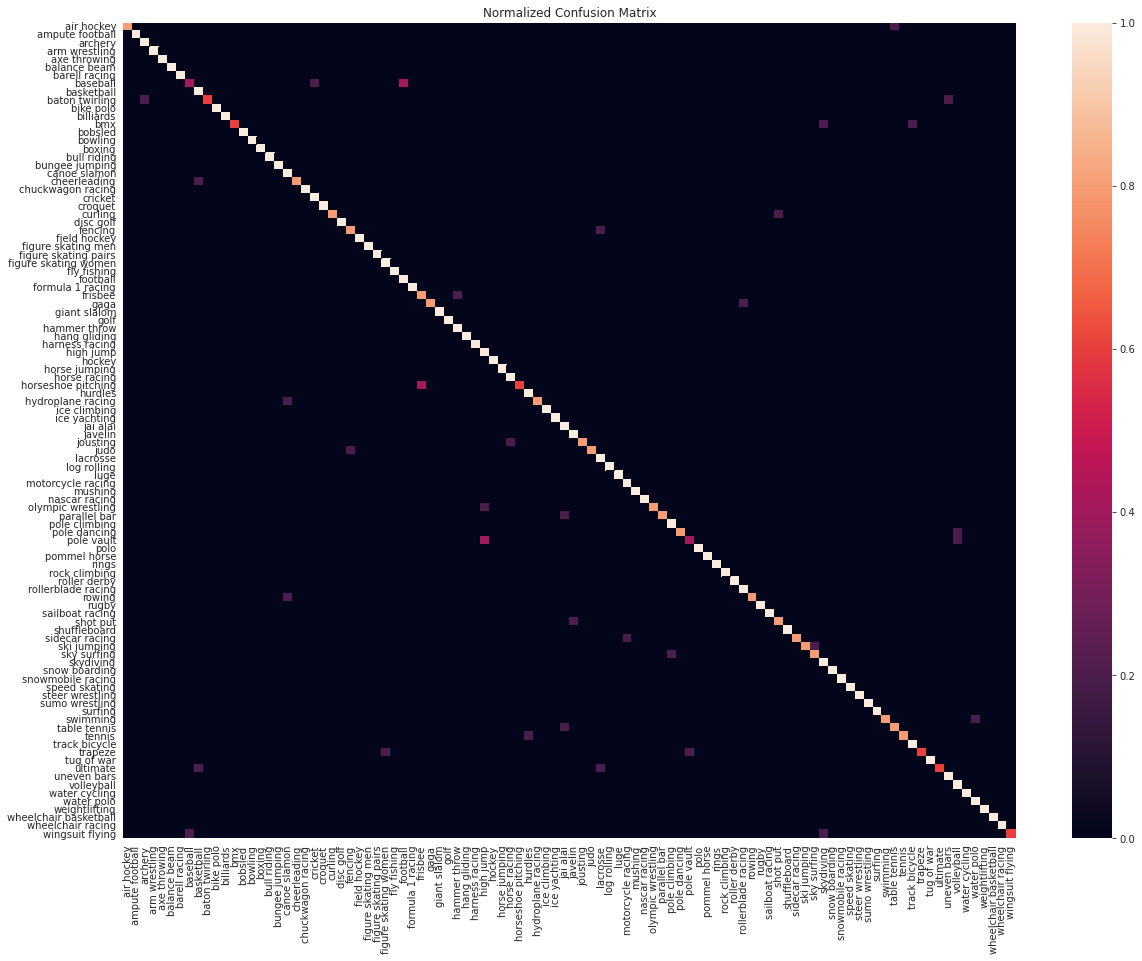

## - 오분류 이미지 시각화

In [ ]:
# 테스트 이미지 경로 및 실제 결과 DataFrame 생성
Filepath = test_generator.filepaths # 테스트 이미지 경로
test_df = pd.DataFrame({'Filepath':Filepath,'Label':y_test},columns=['Filepath','Label'])

In [ ]:
# 오분류된 이미지 추출
diff = []
for i in range(0,500):
  if test_df.Label.iloc[i] != pred[i]:
    diff.append(i)

# 오분류된 이미지 개수
print('오분류된 이미지 개수 :',len(diff))
# 오분류된 이미지 개수 : 38
# 500개 중 38개의 이미지 오분류됨

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
diff_15 = diff[0:15] # 오분류된 이미지 15개 지정

# 오분류된 이미지 상단 15개 추출
for ax, num in zip(axes.flat,diff_15):
  ax.imshow(plt.imread(test_df.Filepath.iloc[num]))
  ax.set_title(f"True: {test_df.Label.iloc[num]}\nPredicted: {pred[num]}")
plt.tight_layout()
plt.show()

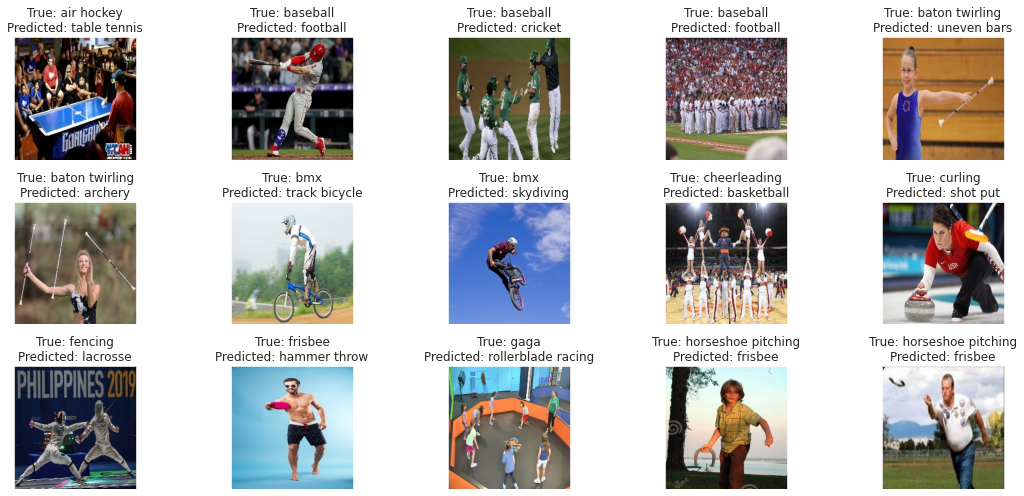